In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from src.embedding import Word2Vec

## Word2Vec: Word Embedding with Continuous Bag of Words and Skipgram Models

Step 1: Define Corpus and Vocabulary

In [2]:
corpus = [
    ["the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"],
    ["a", "fast", "fox", "runs", "past", "the", "sleepy", "cat"],
    ["the", "dog", "barks", "at", "the", "noisy", "crowd"],
    ["cats", "and", "dogs", "live", "together", "in", "peace"],
    ["the", "quick", "hare", "outruns", "the", "slow", "tortoise"],
    ["brown", "foxes", "are", "common", "in", "this", "area"],
    ["lazy", "animals", "sleep", "all", "day", "long"],
    ["the", "noisy", "crowd", "disrupted", "the", "quiet", "park"]
] *10

vocabulary = sorted(list(set([word for sentence in corpus for word in sentence])))
print(f"Vocabulary size: {len(vocabulary)} words")

Vocabulary size: 42 words


Step 2: Initialize and train Word2Vec Models

In [3]:
embedding_dim = 20
context_size = 1

In [4]:
cbow_model = Word2Vec(V=vocabulary, d=embedding_dim, M=context_size, skipgram=False)
skipgram_model = Word2Vec(V=vocabulary, d=embedding_dim, M=context_size, skipgram=True)

In [5]:
cbow_embeddings = cbow_model.embed(
    corpus,
    alpha=0.05,
    epochs=100,
    decay="exp",
    decay_rate=0.9
)

skipgram_embeddings = skipgram_model.embed(
    corpus,
    alpha=0.05,
    epochs=100,
    decay="exp",
    decay_rate=0.9
)

Step 3: Analyze Embeddings

In [6]:
def analyze_embeddings(model, embeddings, name):
    print(f"\n===== {name} Model Analysis =====")
    
    test_words = ["fox", "dog", "quick", "lazy", "noisy"]
    for word in test_words:
        if word not in model.word_ind_map:
            continue
            
        word_idx = model.word_ind_map[word]
        word_vec = embeddings[word_idx].numpy().reshape(1, -1)
        
        all_vecs = embeddings.numpy()
        similarities = cosine_similarity(word_vec, all_vecs)[0]

        top_indices = np.argsort(similarities)[-6:-1][::-1]
        similar_words = [(vocabulary[i], similarities[i]) for i in top_indices]
        print(f"\nWords similar to '{word}':")
        for w, sim in similar_words:
            print(f"{w}: {sim:.3f}")

    def plot_embeddings(embeddings, title):

        pca = PCA(n_components=2)
        tsne = TSNE(n_components=2, perplexity=5)
        
        pca_results = pca.fit_transform(embeddings)
        tsne_results = tsne.fit_transform(embeddings)
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1])
        for i, word in enumerate(vocabulary):
            plt.annotate(word, xy=(pca_results[i, 0], pca_results[i, 1]))
        plt.title(f"{title} - PCA")
        
        plt.subplot(1, 2, 2)
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
        for i, word in enumerate(vocabulary):
            plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]))
        plt.title(f"{title} - t-SNE")
        plt.show()
    
    plot_embeddings(embeddings.numpy(), name)

    def test_analogy(w1, w2, w3):
        try:
            vec = embeddings[model.word_ind_map[w2]] - embeddings[model.word_ind_map[w1]] + embeddings[model.word_ind_map[w3]]
            similarities = cosine_similarity(vec.reshape(1, -1), embeddings.numpy())[0]
            most_similar = vocabulary[np.argmax(similarities)]
            print(f"{w1} : {w2} :: {w3} : {most_similar}")
        except KeyError:
            pass
    
    print("\nAnalogy tests:")
    test_analogy("quick", "fox", "dog")
    test_analogy("lazy", "dog", "cat")


===== CBOW Model Analysis =====

Words similar to 'fox':
common: 0.825
at: 0.806
over: 0.805
together: 0.802
jumps: 0.796

Words similar to 'dog':
cat: 0.794
day: 0.761
past: 0.728
live: 0.719
tortoise: 0.677

Words similar to 'quick':
fox: 0.786
sleep: 0.733
the: 0.701
quiet: 0.675
common: 0.670

Words similar to 'lazy':
day: 0.882
outruns: 0.877
long: 0.851
live: 0.819
all: 0.803

Words similar to 'noisy':
runs: 0.676
this: 0.675
quiet: 0.675
sleepy: 0.653
over: 0.652


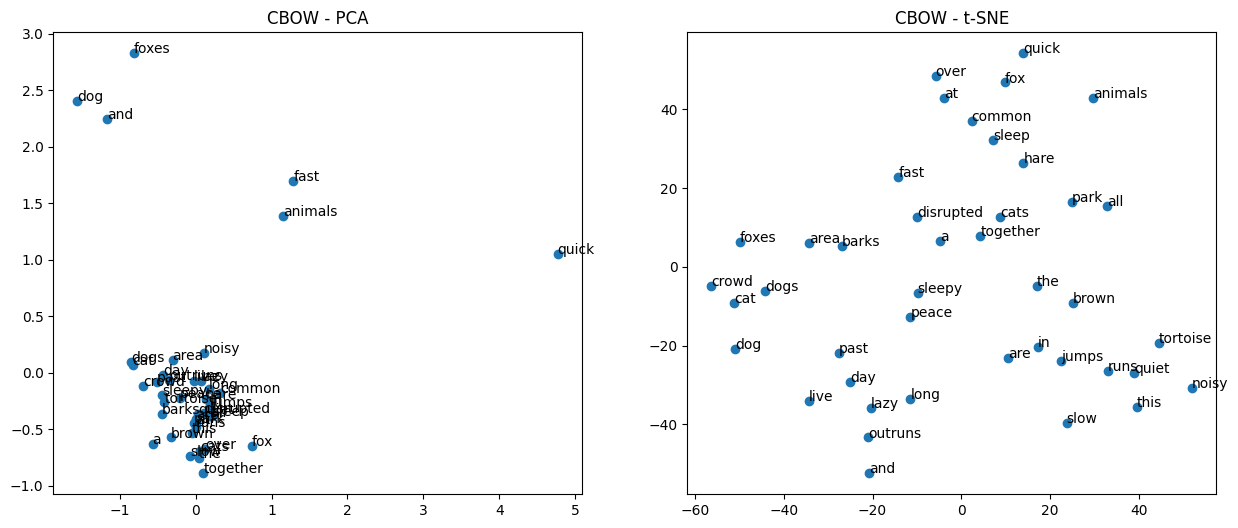


Analogy tests:
quick : fox :: dog : dog
lazy : dog :: cat : dog

===== SkipGram Model Analysis =====

Words similar to 'fox':
lazy: 0.865
long: 0.834
tortoise: 0.832
peace: 0.818
the: 0.802

Words similar to 'dog':
runs: 0.706
sleepy: 0.648
a: 0.647
are: 0.636
past: 0.628

Words similar to 'quick':
barks: 0.714
slow: 0.570
common: 0.562
sleep: 0.554
at: 0.542

Words similar to 'lazy':
fox: 0.865
brown: 0.864
in: 0.854
jumps: 0.836
sleep: 0.822

Words similar to 'noisy':
sleepy: 0.684
long: 0.683
day: 0.650
at: 0.612
disrupted: 0.609


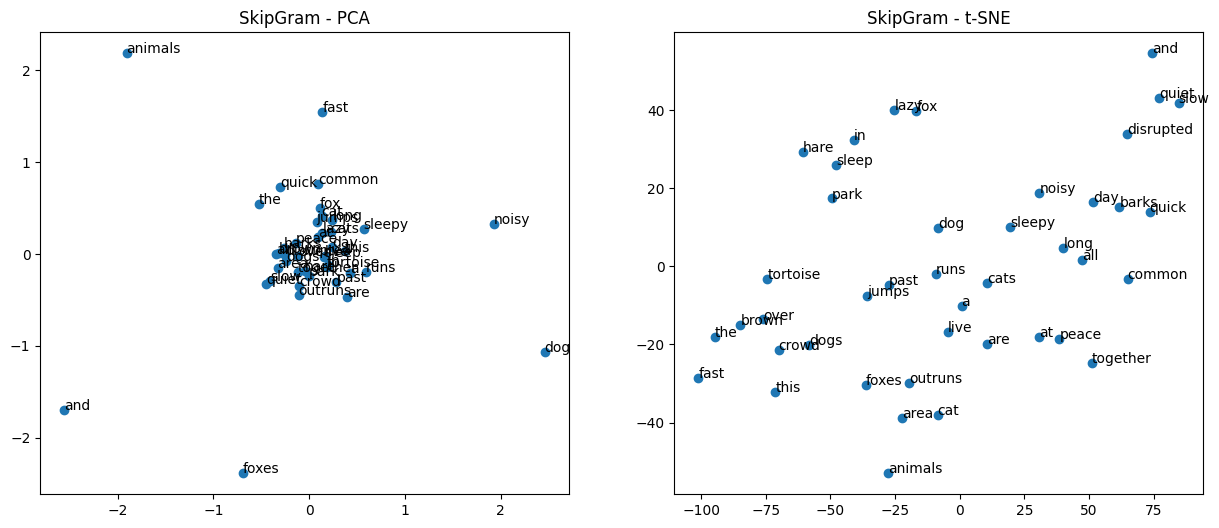


Analogy tests:
quick : fox :: dog : dog
lazy : dog :: cat : dog


In [7]:
analyze_embeddings(cbow_model, cbow_embeddings, "CBOW")
analyze_embeddings(skipgram_model, skipgram_embeddings, "SkipGram")

Step 4: Evaluation

In [8]:
def evaluate_model(model, embeddings):
    synonym_pairs = [("quick", "fast"), ("lazy", "sleepy"), ("noisy", "loud")]
    unrelated_pairs = [("fox", "cat"), ("quick", "sleepy"), ("dog", "park")]
    
    synonym_sims, unrelated_sims = [], []
    
    for w1, w2 in synonym_pairs:
        if w1 in model.word_ind_map and w2 in model.word_ind_map:
            vec1 = embeddings[model.word_ind_map[w1]]
            vec2 = embeddings[model.word_ind_map[w2]]
            synonym_sims.append(torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2)))
    
    for w1, w2 in unrelated_pairs:
        if w1 in model.word_ind_map and w2 in model.word_ind_map:
            vec1 = embeddings[model.word_ind_map[w1]]
            vec2 = embeddings[model.word_ind_map[w2]]
            unrelated_sims.append(torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2)))
    
    print(f"\nMean similarity for synonyms: {torch.mean(torch.tensor(synonym_sims)):.3f}")
    print(f"Mean similarity for unrelated: {torch.mean(torch.tensor(unrelated_sims)):.3f}")
    print(f"Discrimination ratio: {torch.mean(torch.tensor(synonym_sims)) / torch.mean(torch.tensor(unrelated_sims)):.2f}")

In [9]:
print("\n=== CBOW Evaluation ===")
evaluate_model(cbow_model, cbow_embeddings)

print("\n=== SkipGram Evaluation ===")
evaluate_model(skipgram_model, skipgram_embeddings)


=== CBOW Evaluation ===

Mean similarity for synonyms: 0.557
Mean similarity for unrelated: 0.502
Discrimination ratio: 1.11

=== SkipGram Evaluation ===

Mean similarity for synonyms: 0.512
Mean similarity for unrelated: 0.564
Discrimination ratio: 0.91
